# Housekeeping

In [1]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
from numba import njit
import os

### Setting the random seed for reproducibility
np.random.seed(42)

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

## Preparing the data needed

In [2]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_d = pd.read_sql('SELECT * FROM factors_daily', conn).set_index('Date').drop(columns='rf')
factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date')

conn.close()

rf = factor_ret_m[['rf']]
factor_ret_m = factor_ret_m.drop(columns='rf')

### making sure all the data is in the same format
factor_ret_d.index = pd.to_datetime(factor_ret_d.index)
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
rf.index = pd.to_datetime(rf.index)

### Since the BAB factor start in 1983, we will only consider the data from 1983 onwards
factor_ret_d = factor_ret_d['1983':]
factor_ret_m = factor_ret_m['1983':]
rf = rf['1983':]

### Looking if we have any NaN
print(factor_ret_d.isna().sum())
print(factor_ret_m.isna().sum())

SMB    0
HML    0
UMD    0
EW     0
VW     0
BAB    0
dtype: int64
SMB    0
HML    0
UMD    0
EW     0
VW     0
BAB    0
dtype: int64


To compute the monthly volatilities and variances for each factor, we utilize daily data. Since the UMD and BAB factors are constructed by us, we have already applied the respective monthly weights to the daily data. Specifically, at the beginning of each month, we allocate capital to stocks according to that month's predetermined weights, maintaining these positions without rebalancing until the subsequent month.

For the HML, SMB, EW, and VW factors, we assume, for simplicity, that their weights do not exhibit substantial daily variation. Consequently, we use their daily rebalanced returns as a proxy for estimating monthly volatility and variance. This approach ensures consistency across factors while reducing the complexity associated with daily weight adjustments.

In [3]:
### Getting the daily volatilites we are missing using the daily returns
volatility = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
variance = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        volatility.loc[date, factor] = factor_ret_d.loc[date.strftime('%Y-%m'), factor].std() * np.sqrt(252)
        variance.loc[date, factor] = factor_ret_d.loc[date.strftime('%Y-%m'), factor].var() * 252

### Looking if we have any NaN
print(volatility.isna().sum())
print(variance.isna().sum())

SMB    0
HML    0
UMD    0
EW     0
VW     0
BAB    0
dtype: int64
SMB    0
HML    0
UMD    0
EW     0
VW     0
BAB    0
dtype: int64


To ensure that the volatility of both the original factor and the volatility-managed factor remains the same, we will select an appropriate value for $c$. This scaling parameter $c$ is chosen such that the standard deviation of the volatility-managed factor matches that of the original factor.

Mathematically, we define $c$ such that:

$$Std \left ( \frac{c}{\sigma^2_{k,t}} r_{k,t+1} \right ) = Std \left ( r_{k,t+1} \right )$$

In [4]:
### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / variance[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c', factor] = res.x[0]

print(c)

     SMB    HML    UMD     EW     VW    BAB
c 0.0170 0.0197 0.0251 0.0139 0.0184 0.0191


The volatility-timed factors are then defined as:

$$r_{k,t+1}^\sigma=\frac{c}{\sigma^2_{k,t}} r_{k,t+1}$$

In [5]:
### Getting the volatility timed returns
volatility_timed_factors = (c.loc['c',] / variance).shift(1) * factor_ret_m

### Since we are shifting the returns, we will lose the first row, so we will drop it from all data
volatility_timed_factors = volatility_timed_factors.dropna()
factor_ret_m = factor_ret_m.loc[volatility_timed_factors.index]
rf = rf.loc[volatility_timed_factors.index]

### Looking if we have any NaN
print(volatility_timed_factors.isna().sum())

### Checking that the volatility timed factors have the same volatility as the original factors
print(volatility_timed_factors.std() - factor_ret_m.std())

SMB    0
HML    0
UMD    0
EW     0
VW     0
BAB    0
dtype: int64
SMB   -0.0000
HML   -0.0000
UMD   -0.0000
EW    -0.0000
VW    -0.0000
BAB   -0.0000
dtype: object


Now, we construct new dataframes that incorporate both the volatility-timed factor and the original factor. We then apply mean-variance optimization, utilizing the past five years of data to determine the optimal weights for both returns and a risk-free asset. 

Since we are working with excess returns, the excess return on the risk-free asset is $0\%$. In accordance with the referenced paper, we set $\gamma = 5$, although the choice of $\gamma$ does not impact the Sharpe ratios significantly. 

To ensure more realistic results, we impose a no-short-selling constraint. Given that the factors are correlated, allowing short selling could lead the optimization to exploit an apparent "arbitrage" opportunity, resulting in unrealistic weight allocations.


In [6]:
### Creating a dataframe for each factor with the normal and volatility timed returns
factor_dataframes = {}
for factor in factor_ret_m.columns:
    factor_df = pd.DataFrame(columns=['Normal', 'Volatility Timed'], index=factor_ret_m.index)
    factor_df['Normal'] = factor_ret_m[factor]
    factor_df['Volatility Timed'] = volatility_timed_factors[factor]
    factor_dataframes[factor] = factor_df.astype(float)

# Create an empty DataFrame to store in-sample volatility managed factor portfolio returns
w = 120  # Window size for rolling calculation
volatility_managed_factor_ptf_insample = pd.DataFrame(columns=factor_ret_m.columns, index=factor_ret_m.index).iloc[w:,]
volatility_managed_factor_ptf_outofsample = pd.DataFrame(columns=factor_ret_m.columns, index=factor_ret_m.index).iloc[w:,]

# Loop through each factor to calculate in-sample volatility managed returns
for factor in factor_ret_m.columns:
    dates = factor_dataframes[factor].index
    for i in range(w, len(factor_dataframes[factor])):
        # Get the returns for the past 'w' months
        ret = factor_dataframes[factor].loc[dates[i-w]:dates[i-1]]

        # Getting the weights
        weight = ptf_weights(ret, negative=False, type = "MVP", gamma = 5)

        # Calculate the portfolio weights and apply them to the current month's returns
        volatility_managed_factor_ptf_insample.loc[dates[i], factor] = (weight * factor_dataframes[factor].loc[dates[i-1]].values).sum()
        volatility_managed_factor_ptf_outofsample.loc[dates[i], factor] = (weight * factor_dataframes[factor].loc[dates[i]].values).sum()

### Replacing the NaN values with 0 since we have some months where we only invest in the risk-free rate
volatility_managed_factor_ptf_insample = volatility_managed_factor_ptf_insample.fillna(0)
volatility_managed_factor_ptf_outofsample = volatility_managed_factor_ptf_outofsample.fillna(0)

### Getting the sharpes ratios
SR = pd.DataFrame(columns=factor_ret_m.columns)
SR.loc['Orginal', :] = sharpes_ratio(factor_ret_m)
SR.loc['Volatility Managed Factor', :] = sharpes_ratio(volatility_timed_factors)
SR.loc['Volatility Managed Factor Portfolio In-Sample', :] = sharpes_ratio(volatility_managed_factor_ptf_insample)
SR.loc['Volatility Managed Factor Portfolio Out-of-Sample', :] = sharpes_ratio(volatility_managed_factor_ptf_outofsample)
SR

,SMB,HML,UMD,EW,VW,BAB
Orginal,0.8157,0.3184,1.0066,0.4095,0.8278,0.8119
Volatility Managed Factor,0.7984,0.2277,1.2638,0.4669,0.8500,0.4282
Volatility Managed Factor Portfolio In-Sample,1.0150,0.2693,1.4745,0.6404,1.0166,0.9193
Volatility Managed Factor Portfolio Out-of-Sample,0.9558,0.1350,1.4334,0.5652,0.9225,0.8709


Next, we compute the p-values for the Sharpe ratios to determine the proportion of times, out of $n_{\text{boot}}$ simulations, that the Sharpe ratio exceeds that of the original factor. 

To account for potential trends in the data, we employ stationary bootstrapping in our resampling procedure.


In [7]:
### Creating a dataframe for each factor with the normal and volatility managed returns
factor_returns = {}
factor_returns_outofsample = {}
factor_returns_insample = {}

for factor in factor_ret_m.columns:
    df = pd.DataFrame(columns=['Normal', 'Volatility Managed'], index=factor_ret_m.index)
    df['Normal'] = factor_ret_m[factor]
    df['Volatility Managed'] = volatility_managed_factor_ptf_outofsample[factor]
    factor_returns_outofsample[factor] = df.dropna()

    df = df.drop(['Volatility Managed'], axis=1)
    df['Volatility Managed'] = volatility_managed_factor_ptf_insample[factor]
    factor_returns_insample[factor] = df.dropna()

    df = df.drop(['Volatility Managed'], axis=1)
    df['Volatility Managed'] = volatility_timed_factors[factor]
    factor_returns[factor] = df.dropna()

### Getting the p-values
p_values = pd.DataFrame(columns=factor_ret_m.columns, index=['Individual','In-Sample', 'Out-of-Sample'])
n_boot = 100000

for factor in factor_ret_m.columns:

    ### Getting the p-values for the individual factors
    SR_diff = []
    ret = factor_returns[factor].astype(float).dropna()
    for i in range(n_boot):
        boot = stationary_bootstrap_multivariate(np.array(ret), 5, len(ret))
        SR_diff.append((sharpes_ratio(boot[:,1]) - sharpes_ratio(boot[:,0])))
    p_values.loc['Individual', factor] = (np.sum(np.array(SR_diff) < 0) / len(SR_diff))

    ### Getting the p-values for the in-sample volatility managed factors
    SR_diff = []
    ret = factor_returns_insample[factor].astype(float).dropna()
    for i in range(n_boot):
        boot = stationary_bootstrap_multivariate(np.array(ret), 5, len(ret))
        SR_diff.append((sharpes_ratio(boot[:,1]) - sharpes_ratio(boot[:,0])))
    p_values.loc['In-Sample', factor] = (np.sum(np.array(SR_diff) < 0) / len(SR_diff))
    
    ### Getting the p-values for the out-of-sample volatility managed factors
    SR_diff = []
    ret = factor_returns_outofsample[factor].astype(float).dropna()
    for i in range(n_boot):
        boot = stationary_bootstrap_multivariate(np.array(ret), 5, len(ret))
        SR_diff.append((sharpes_ratio(boot[:,1]) - sharpes_ratio(boot[:,0])))
    p_values.loc['Out-of-Sample', factor] = (np.sum(np.array(SR_diff) < 0) / len(SR_diff))

### Looking at the p-values
p_values

,SMB,HML,UMD,EW,VW,BAB
Individual,0.6048,0.8805,0.0191,0.3293,0.4470,0.8686
In-Sample,0.3155,0.4170,0.0235,0.3221,0.3851,0.5120
Out-of-Sample,0.4907,0.9541,0.0053,0.5146,0.7721,0.6928


In [8]:
### Creating latex table
latex = pd.DataFrame(columns=factor_ret_m.columns)

latex.loc['SR($r_k$)', :] = sharpes_ratio(factor_ret_m)
latex.loc['SR($r_k^\sigma$)', :] = sharpes_ratio(volatility_timed_factors)
latex.loc['p-value(SR($r_k^\sigma$) - SR($r_k$))', :] = p_values.loc['Individual', :]

latex.loc['SR($r_k$)2', :] = sharpes_ratio(factor_ret_m)
latex.loc['SR($r_k$, $r_k^\sigma$)', :] = sharpes_ratio(volatility_managed_factor_ptf_insample)
latex.loc['p-value(SR($r_k$, $r_k^\sigma$) - SR($r_k$))2', :] = p_values.loc['In-Sample', :]

latex.loc['SR($r_k$)3', :] = sharpes_ratio(factor_ret_m)
latex.loc['SR($r_k$, $r_k^\sigma$)2', :] = sharpes_ratio(volatility_managed_factor_ptf_outofsample)
latex.loc['p-value(SR($r_k$, $r_k^\sigma$) - SR($r_k$))3', :] = p_values.loc['Out-of-Sample', :]

latex

,SMB,HML,UMD,EW,VW,BAB
SR($r_k$),0.8157,0.3184,1.0066,0.4095,0.8278,0.8119
SR($r_k^\sigma$),0.7984,0.2277,1.2638,0.4669,0.8500,0.4282
p-value(SR($r_k^\sigma$) - SR($r_k$)),0.6048,0.8805,0.0191,0.3293,0.4470,0.8686
SR($r_k$)2,0.8157,0.3184,1.0066,0.4095,0.8278,0.8119
"SR($r_k$, $r_k^\sigma$)",1.0150,0.2693,1.4745,0.6404,1.0166,0.9193
"p-value(SR($r_k$, $r_k^\sigma$) - SR($r_k$))2",0.3155,0.4170,0.0235,0.3221,0.3851,0.5120
SR($r_k$)3,0.8157,0.3184,1.0066,0.4095,0.8278,0.8119
"SR($r_k$, $r_k^\sigma$)2",0.9558,0.1350,1.4334,0.5652,0.9225,0.8709
"p-value(SR($r_k$, $r_k^\sigma$) - SR($r_k$))3",0.4907,0.9541,0.0053,0.5146,0.7721,0.6928


In [9]:
print(latex.to_latex(float_format="%.3f"))

\begin{tabular}{lllllll}
\toprule
 & SMB & HML & UMD & EW & VW & BAB \\
\midrule
SR($r_k$) & 0.816 & 0.318 & 1.007 & 0.409 & 0.828 & 0.812 \\
SR($r_k^\sigma$) & 0.798 & 0.228 & 1.264 & 0.467 & 0.850 & 0.428 \\
p-value(SR($r_k^\sigma$) - SR($r_k$)) & 0.605 & 0.880 & 0.019 & 0.329 & 0.447 & 0.869 \\
SR($r_k$)2 & 0.816 & 0.318 & 1.007 & 0.409 & 0.828 & 0.812 \\
SR($r_k$, $r_k^\sigma$) & 1.015 & 0.269 & 1.475 & 0.640 & 1.017 & 0.919 \\
p-value(SR($r_k$, $r_k^\sigma$) - SR($r_k$))2 & 0.315 & 0.417 & 0.023 & 0.322 & 0.385 & 0.512 \\
SR($r_k$)3 & 0.816 & 0.318 & 1.007 & 0.409 & 0.828 & 0.812 \\
SR($r_k$, $r_k^\sigma$)2 & 0.956 & 0.135 & 1.433 & 0.565 & 0.923 & 0.871 \\
p-value(SR($r_k$, $r_k^\sigma$) - SR($r_k$))3 & 0.491 & 0.954 & 0.005 & 0.515 & 0.772 & 0.693 \\
\bottomrule
\end{tabular}



In [10]:
factor_ret_m

,SMB,HML,UMD,EW,VW,BAB
Date,,,,,,
1983-02-28,0.0035,-0.0356,0.0179,0.0754,0.0703,-0.0507
1983-03-31,0.1177,-0.0142,0.0551,0.1207,0.0604,-0.0054
1983-04-30,-0.0362,0.2283,0.0563,0.1251,0.1995,0.0300
1983-05-31,-0.0331,-0.0739,0.0100,-0.0440,-0.0177,0.0931
1983-06-30,-0.0643,0.1406,-0.0050,-0.0258,0.0228,-0.0305
...,...,...,...,...,...,...
2023-08-31,-0.0390,0.0525,0.0229,-0.0225,0.0164,-0.0488
2023-09-30,0.0100,0.0063,-0.0022,0.0004,0.0336,0.0478
2023-10-31,-0.0381,0.0271,0.0911,-0.0364,0.0057,-0.0551


In [11]:
volatility_timed_factors

,SMB,HML,UMD,EW,VW,BAB
Date,,,,,,
1983-02-28,0.0007,-0.0063,0.0081,0.0289,0.0204,-0.0064
1983-03-31,0.0175,-0.0019,0.0128,0.0380,0.0251,-0.0010
1983-04-30,-0.0084,0.0374,0.0250,0.0377,0.1100,0.0031
1983-05-31,-0.0083,-0.0139,0.0050,-0.0224,-0.0108,0.0330
1983-06-30,-0.0150,0.0252,-0.0042,-0.0611,0.0339,-0.0043
...,...,...,...,...,...,...
2023-08-31,-0.0967,0.1613,0.0440,-0.0333,0.0200,-0.1327
2023-09-30,0.0149,0.0093,-0.0057,0.0008,0.0327,0.1082
2023-10-31,-0.0501,0.0583,0.2880,-0.0442,0.0102,-0.1510


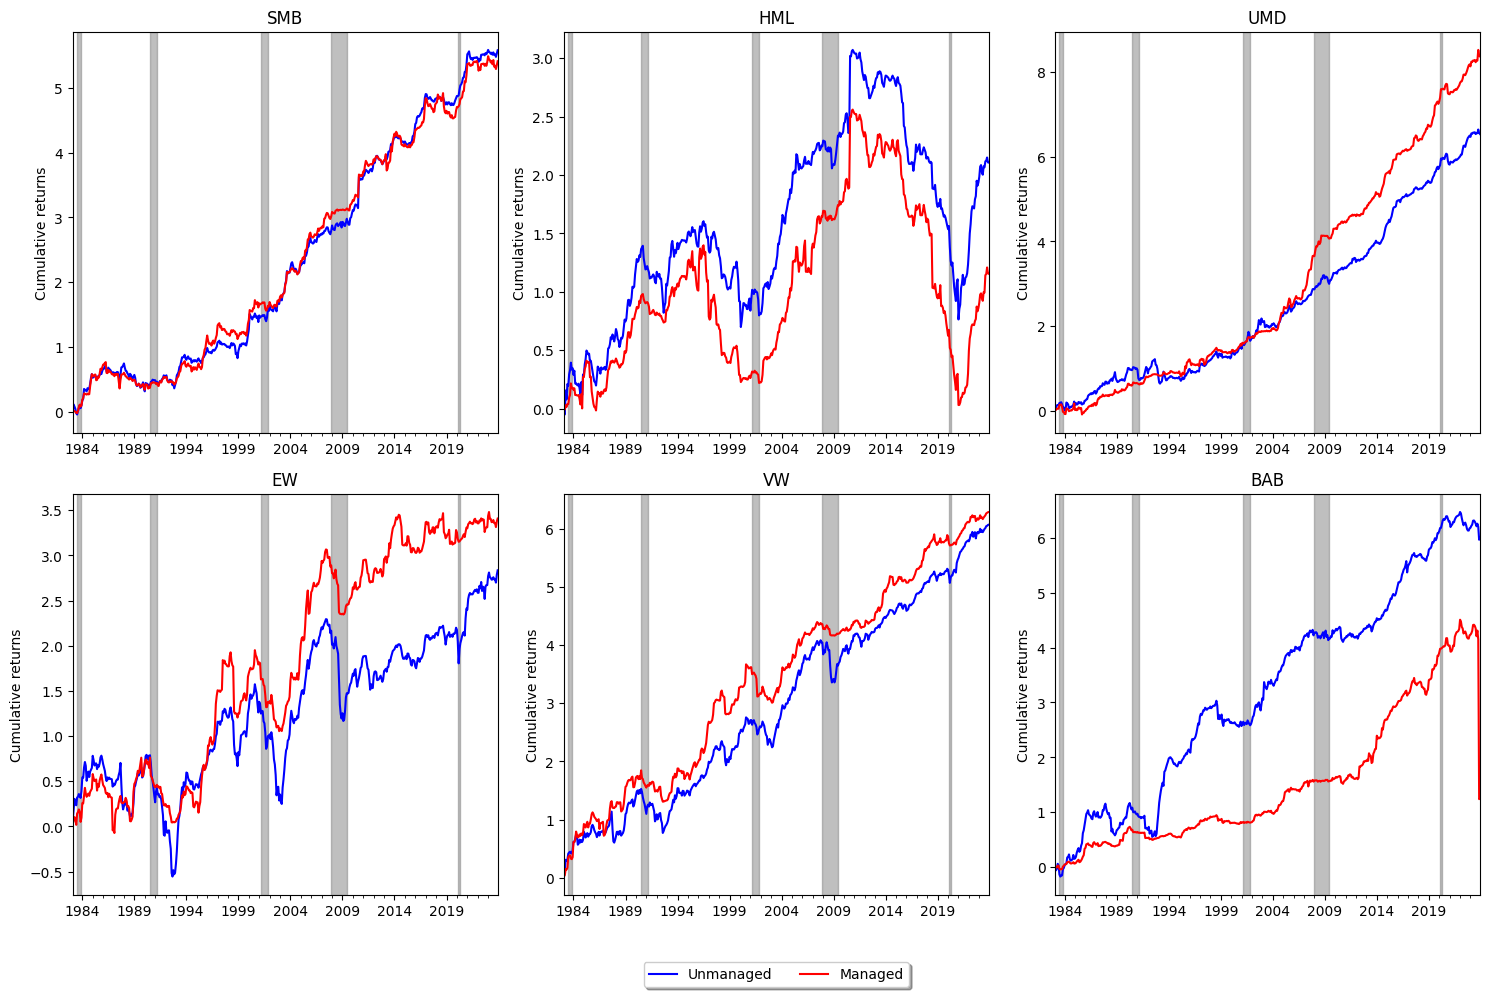

In [12]:
### Plotting cumulative returns for all the 6 factors volatility managed and not. In a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Define the recession periods
recessions = [
    ('1983-07-01', '1983-11-30'),
    ('1990-07-01', '1991-03-31'),
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

for i, factor in enumerate(factor_ret_m.columns):
    np.log(1 + factor_ret_m[factor].astype(float)).cumsum().plot(ax=axs[i], title=factor, color='blue', label='Unmanaged')
    np.log(1 + volatility_timed_factors[factor].astype(float)).cumsum().plot(ax=axs[i], title=factor, color='red', label='Managed')

    # Add grey fields for recessions
    for start, end in recessions:
        axs[i].axvspan(start, end, color='grey', alpha=0.5)

    # Remove the x-axis label
    axs[i].set_xlabel('')
    # Set the y-axis label
    axs[i].set_ylabel('Cumulative returns')

    if factor == "VW":
        # adding a legend under the plot
        axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.tight_layout()
plt.savefig('Plots/cumulative_returns_factors.png')
plt.show()

In [13]:
### Storing the data
conn = sqlite3.connect('Data/data.db')

volatility.to_sql('volatility', conn, if_exists='replace')
variance.to_sql('variance', conn, if_exists='replace')
volatility_timed_factors.to_sql('volatility_timed_factors', conn, if_exists='replace')
volatility_managed_factor_ptf_insample.to_sql('volatility_managed_factor_ptf_insample', conn, if_exists='replace')
volatility_managed_factor_ptf_outofsample.to_sql('volatility_managed_factor_ptf_outofsample', conn, if_exists='replace')

conn.close()